In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from dotenv import load_dotenv
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
load_dotenv()

True

In [31]:
def load_metrics(filename):
    with open(filename, 'r') as f:
        metrics = json.load(f)
        return pd.DataFrame(metrics)

In [32]:
metrics = [ {'label': 'Simple',
             'df': load_metrics('metrics/training_metrics_scratch_01.json'),
             'colours': '#1f77b4'},
            {'label': 'Medium',
             'df': load_metrics('metrics/training_metrics_scratch_05_complex.json'),
             'colours': '#ff7f0e'},
            {'label': 'Complex',
             'df': load_metrics('metrics/training_metrics_scratch_06.json'),
             'colours': '#2ca02c'}]

In [33]:
def plot_metrics(metrics, image_path):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    for single_metric in metrics:
        df = single_metric['df']
        colours = single_metric['colours']
        label = single_metric['label']
        axes[0].plot(df['epoch'], df['train_loss'], label=f'Train [{label}]', color=colours, linestyle='-', linewidth=4)
        axes[1].plot(df['epoch'], df['train_accuracy'], label=f'Train [{label}]', color=colours, linestyle='-', linewidth=4)

        axes[0].plot(df['epoch'], df['test_loss'], label=f'Validation [{label}]', color=colours, linestyle='-.', linewidth=2)
        axes[1].plot(df['epoch'], df['test_accuracy'], label=f'Validation [{label}]', color=colours, linestyle='-.', linewidth=2)

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    plt.tight_layout()

    plt.savefig(image_path, bbox_inches='tight')
    plt.show()


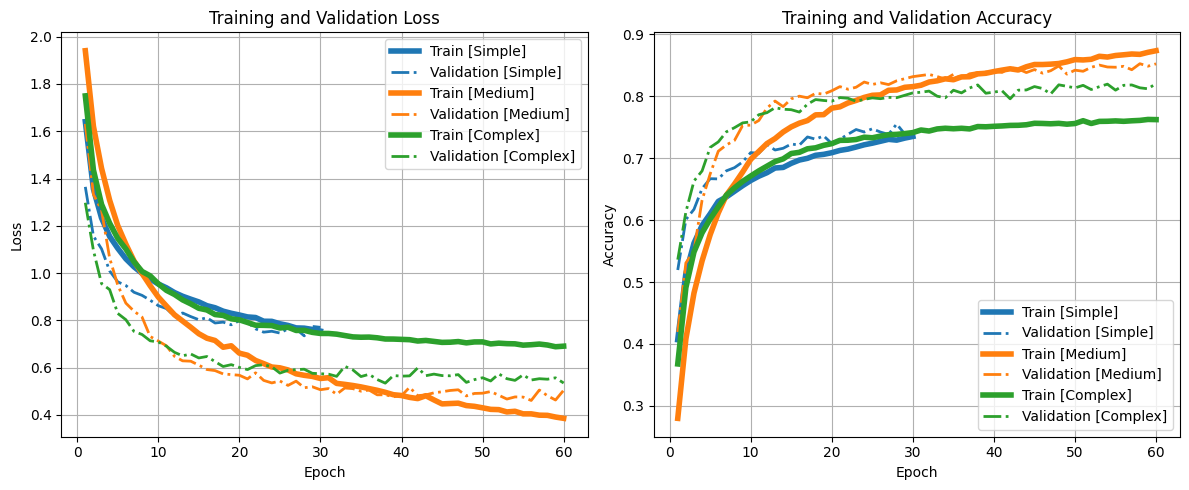

In [34]:
plot_metrics(metrics, image_path='report/media/training_metrics_scratch_01.png')

In [54]:
metrics_pre_trained = [{'label': 'MobilNet[64x64]',
                        'df': load_metrics('metrics/training_metrics_mobilnet_full.json'),
                        'colours': '#d62728'},
                       {'label': 'ResNet18[Tut. P1]',
                        'df': load_metrics('metrics/training_metrics_transfer_learning_tutorial_first_part.json'),
                        'colours': '#9467bd'},
                       {'label': 'ResNet18[Tut. P2]',
                        'df': load_metrics('metrics/training_metrics_transfer_learning_tutorial_second_part.json'),
                        'colours': '#8c564b'},
                       {'label': 'ResNet50[224x224]',
                        'df': load_metrics('metrics/training_metrics_resnet_01.json'),
                        'colours': '#17becf'},
                       {'label': 'MobilNet[224x224]',
                        'df': load_metrics('metrics/training_metrics_mobilnet_224.json'),
                        'colours': '#bcbd22'},
                       {'label': 'EfficientNet[32x32]',
                        'df': load_metrics('metrics/training_metrics_efficient.json'),
                        'colours': '#1f77b4'}]

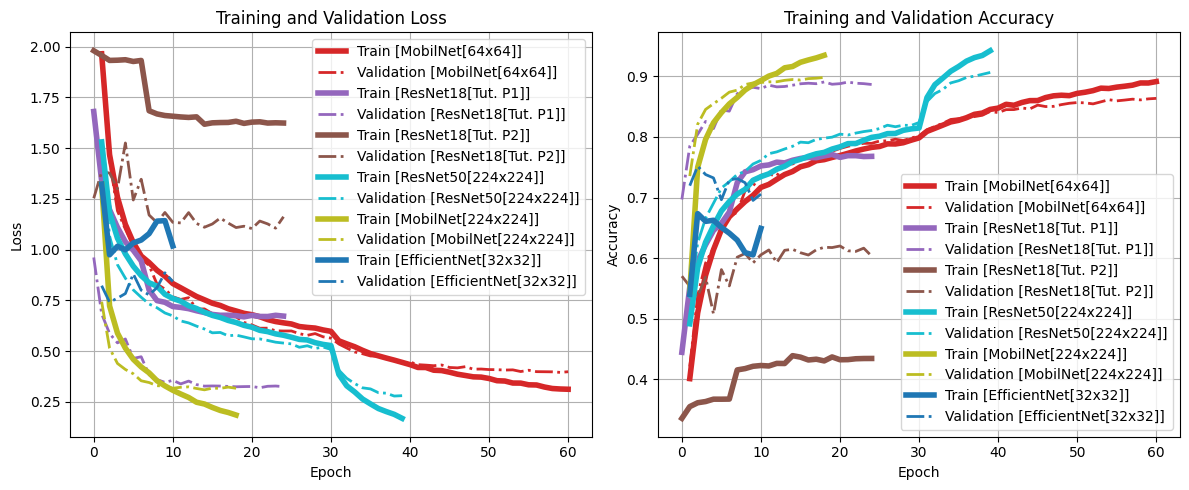

In [55]:
plot_metrics(metrics_pre_trained, image_path='report/media/training_metrics_pretrained_01.png')

In [3]:
f"{os.getenv("DATA_MODELS_PATH")}"

'/home/vmchura/DataspellProjects/practice_pytorch_images/models'

In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch

In [12]:
def test_iteration(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    average_loss = 0
    average_accuracy = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            average_loss += loss_fn(predictions, labels).item()
            average_accuracy += (predictions.argmax(1) == labels).type(torch.float).sum().item()
    average_loss /= num_batches
    average_accuracy /= size
    return {'average_loss': average_loss, 'average_accuracy': average_accuracy}

Using cache found in /home/vmchura/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
def predict_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


In [57]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_names, image_path):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(image_path, bbox_inches='tight')
    plt.show()


In [43]:

print(device)

cpu


In [50]:
scratch_05_complex_transformation = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
scratch_05_complex_dataset = datasets.ImageFolder(root=os.getenv('DATA_IMAGES_PATH'), transform=scratch_05_complex_transformation)
scratch_05_complex_loader = torch.utils.data.DataLoader(scratch_05_complex_dataset, batch_size=32, shuffle=False)

class ImageClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))

        x = x.view(-1, 512 * 4 * 4)

        x = self.dropout1(self.relu5(self.fc1(x)))
        x = self.dropout2(self.relu6(self.fc2(x)))
        x = self.fc3(x)
        return x

    def predict(self, x):
        return torch.softmax(self.forward(x), dim=1)

scratch_05_complex_model = ImageClassifier(num_classes=len(scratch_05_complex_dataset.classes)).to(device)
scratch_05_complex_loss_fn = nn.CrossEntropyLoss()
scratch_05_complex_model = scratch_05_complex_model.to(device)
scratch_05_complex_model_checkpoint = torch.load(os.path.join(os.getenv('DATA_MODELS_PATH'), 'model_checkpoint_scratch_05_complex.pth'), map_location=device)
scratch_05_complex_model.load_state_dict(scratch_05_complex_model_checkpoint['model_state_dict'])

<All keys matched successfully>

In [51]:
scratch_06_transformation = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
class ImageClassifier_06(nn.Module):
    def __init__(self, num_classes=10):
        super(ImageClassifier_06, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.bn1(self.relu1(self.conv1(x))))
        x = self.pool2(self.bn2(self.relu2(self.conv2(x))))
        x = self.pool3(self.bn3(self.relu3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout1(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

    def predict(self, x):
        return torch.softmax(self.forward(x), dim=1)

scratch_06_dataset = datasets.ImageFolder(root=os.getenv('DATA_IMAGES_PATH'), transform=scratch_06_transformation)
scratch_06_loader = torch.utils.data.DataLoader(scratch_06_dataset, batch_size=32, shuffle=False)
scratch_06_model = ImageClassifier_06(num_classes=len(scratch_06_dataset.classes)).to(device)
scratch_06_loss_fn = nn.CrossEntropyLoss()
scratch_06_model = scratch_06_model.to(device)
scratch_06_model_checkpoint = torch.load(os.path.join(os.getenv('DATA_MODELS_PATH'), 'model_checkpoint_scratch_06.pth'), map_location=device)
scratch_06_model.load_state_dict(scratch_06_model_checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
mobilnet_64_transformation = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mobilnet_64_dataset = datasets.ImageFolder(root=os.getenv('DATA_IMAGES_PATH'), transform=mobilnet_64_transformation)
mobilnet_64_loader = torch.utils.data.DataLoader(mobilnet_64_dataset, batch_size=32, shuffle=False)
mobilnet_64_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.MobileNet_V2_Weights.DEFAULT)
mobilnet_64_model.classifier[1] = nn.Sequential(
    nn.Linear(mobilnet_64_model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(mobilnet_64_dataset.classes))
)
mobilnet_64_loss_fn = nn.CrossEntropyLoss()
mobilnet_64_model = mobilnet_64_model.to(device)
mobilnet_64_model_checkpoint = torch.load(os.path.join(os.getenv('DATA_MODELS_PATH'), 'mobilnet_full.pth'), map_location=device)
mobilnet_64_model.load_state_dict(mobilnet_64_model_checkpoint['model_state_dict'])

Using cache found in /home/vmchura/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [20]:
resnet50_transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
resnet50_dataset = datasets.ImageFolder(root=os.getenv('DATA_IMAGES_PATH'), transform=resnet50_transformation)
resnet50_loader = torch.utils.data.DataLoader(resnet50_dataset, batch_size=32, shuffle=False)
resnet50_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, len(resnet50_dataset.classes))
resnet50_loss_fn = nn.CrossEntropyLoss()
resnet50_model = resnet50_model.to(device)
resnet50_model_checkpoint = torch.load(os.path.join(os.getenv('DATA_MODELS_PATH'), 'resnet_01.pth'), map_location=device)
resnet50_model.load_state_dict(resnet50_model_checkpoint['model_state_dict'])

<All keys matched successfully>

In [23]:
mobilnet_224_transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mobilnet_224_dataset = datasets.ImageFolder(root=os.getenv('DATA_IMAGES_PATH'), transform=mobilnet_224_transformation)
mobilnet_224_loader = torch.utils.data.DataLoader(mobilnet_224_dataset, batch_size=32, shuffle=False)
mobilnet_224_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.MobileNet_V2_Weights.DEFAULT)
mobilnet_224_model.classifier[1] = nn.Linear(mobilnet_224_model.classifier[1].in_features, len(mobilnet_224_dataset.classes))
mobilnet_224_loss_fn = nn.CrossEntropyLoss()
mobilnet_224_model = mobilnet_224_model.to(device)
mobilnet_224_model_checkpoint = torch.load(os.path.join(os.getenv('DATA_MODELS_PATH'), 'mobilnet_224.pth'), map_location=device)
mobilnet_224_model.load_state_dict(mobilnet_224_model_checkpoint['model_state_dict'])

Using cache found in /home/vmchura/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [21]:
test_iteration(mobilnet_64_loader, mobilnet_64_model, mobilnet_64_loss_fn)

{'average_loss': 0.40830922350287435, 'average_accuracy': 0.8636}

In [22]:
test_iteration(resnet50_loader, resnet50_model, resnet50_loss_fn)

{'average_loss': 0.28979302650388283, 'average_accuracy': 0.9064}

In [24]:
test_iteration(mobilnet_224_loader, mobilnet_224_model, mobilnet_224_loss_fn)

{'average_loss': 0.3167139710337757, 'average_accuracy': 0.8899}

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Confusion Matrix for Model 0:


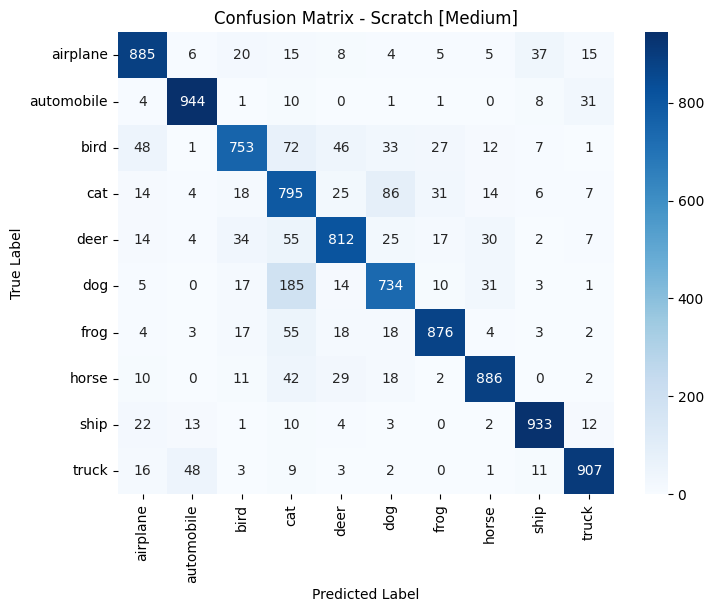

Confusion Matrix for Model 1:


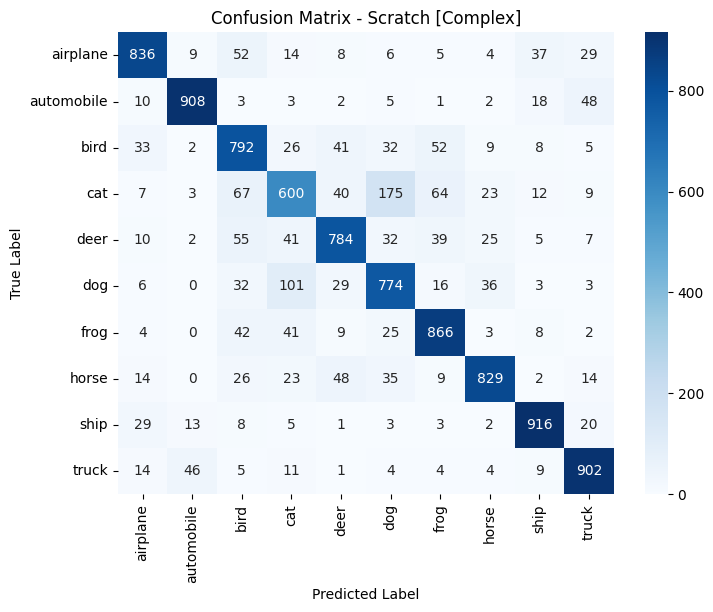

Confusion Matrix for Model 2:


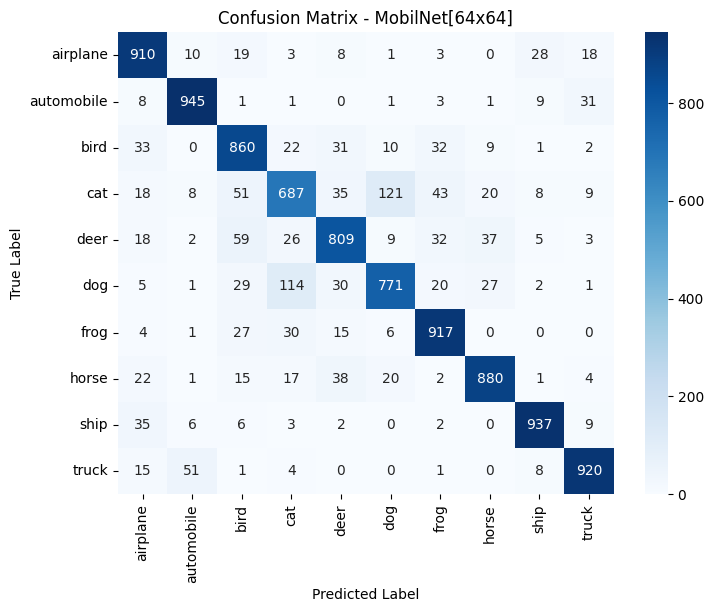

Confusion Matrix for Model 3:


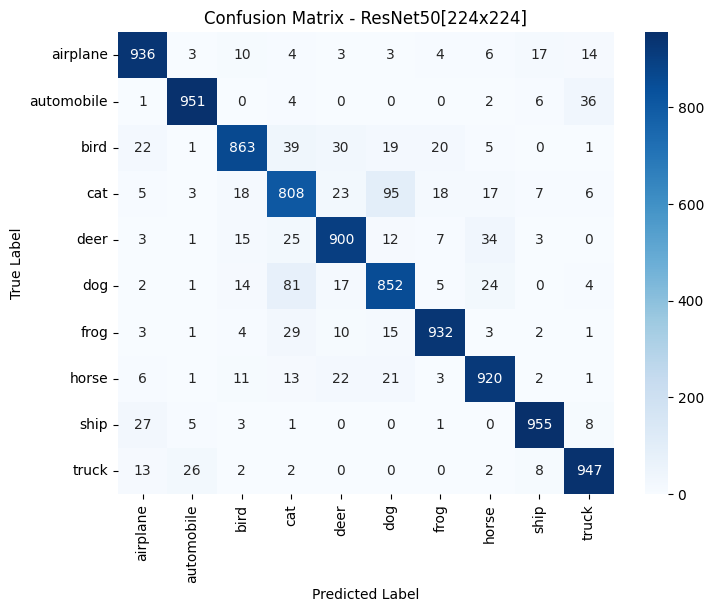

Confusion Matrix for Model 4:


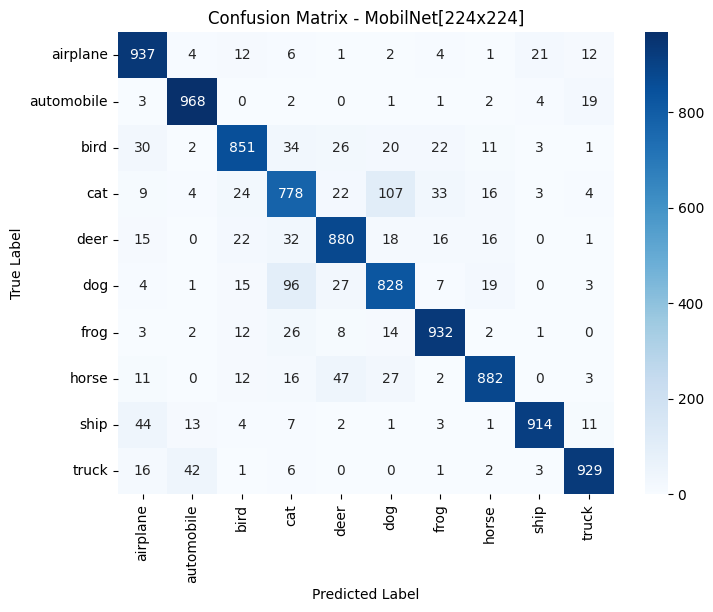

In [58]:
for idx, (model_name, model_iteration, loader_iteration, image_path) in enumerate([
    ('Scratch [Medium]',scratch_05_complex_model, scratch_05_complex_loader, 'report/media/confusion_matrix_scratch05_complex.png'),
    ('Scratch [Complex]',scratch_06_model, scratch_06_loader, 'report/media/confusion_matrix_scratch06.png'),
    ('MobilNet[64x64]',mobilnet_64_model, mobilnet_64_loader, 'report/media/confusion_matrix_mobilnet64.png'),
    ('ResNet50[224x224]',resnet50_model, resnet50_loader, 'report/media/confusion_matrix_resnet50.png'),
    ('MobilNet[224x224]',mobilnet_224_model, mobilnet_224_loader, 'report/media/confusion_matrix_mobilnet224.png'),]):
    model_iteration.to(device)
    y_true, y_pred = predict_labels(model_iteration, loader_iteration)

    print(f"Confusion Matrix for Model {idx}:")
    plot_confusion_matrix(y_true, y_pred, model_name=f"{model_name}", class_names=mobilnet_64_dataset.classes, image_path=image_path)
